# Morphology

Relevant photutils websites:

https://photutils.readthedocs.io/en/stable/morphology.html

In [1]:
import os
import numpy as np
from glob import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from astropy.stats import SigmaClip, sigma_clipped_stats, mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus 
from photutils import Background2D, MedianBackground
%matplotlib inline

## Load the image

In [2]:
im,head = fits.getdata('data/DoubleCluster-0023B_red.fit',0,header=True)

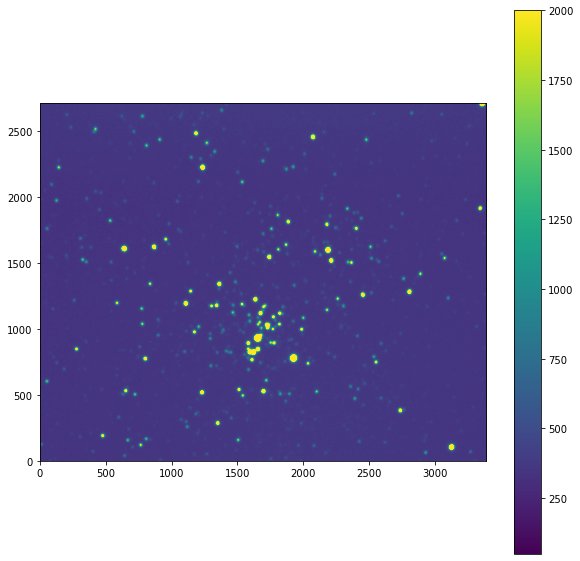

In [3]:
fig = plt.figure(figsize=(10,10))
plt.imshow(im,origin='lower',vmin=50,vmax=2000)
plt.colorbar()

## Subtract the background

In [4]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(im, (200, 200), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
# Subtract the background
sim = im - bkg.background

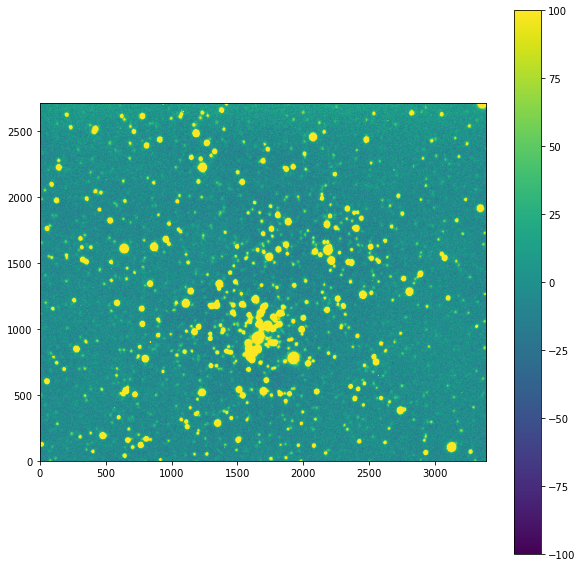

In [5]:
fig = plt.figure(figsize=(10,10))
plt.imshow(sim,origin='lower',vmin=-100,vmax=100)
plt.colorbar()

In [6]:
print(np.median(sim))

2.7263918753917835


# Centroiding
Pick a bright star to work on

In [7]:
im2 = sim[165:220,450:500].copy()

In [8]:
mn, med, sig = sigma_clipped_stats(im2,sigma=3)
print(mn)
print(med)
print(sig)

212.22248844568554
140.8372972123455
220.40629687223654


In [9]:
# Set negative values to zero
im2[im2<0] = 0

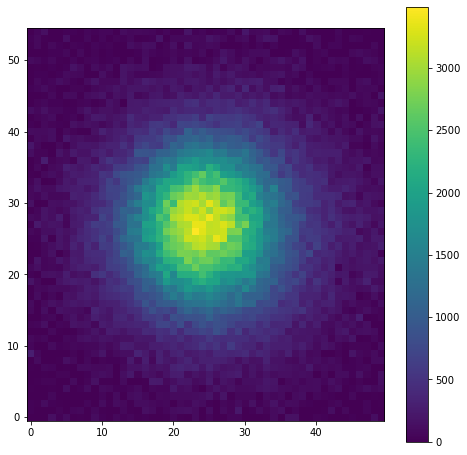

In [10]:
fig = plt.figure(figsize=(8,8))
plt.imshow(im2,origin='lower')
plt.colorbar()

In [11]:
# Create array of x-values for the image
ny,nx = im2.shape
xx,yy = np.meshgrid(np.arange(nx)+450,np.arange(ny)+165)

In [12]:
mnx = np.sum(im2*xx) / np.sum(im2)
print(mnx)
mny = np.sum(im2*yy) / np.sum(im2)
print(mny)

474.8470153249054
191.82351398004275


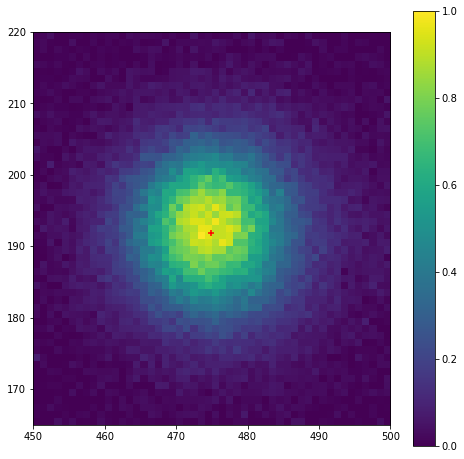

In [13]:
fig = plt.figure(figsize=(8,8))
plt.imshow(im2,origin='lower',extent=(450,500,165,220))
plt.scatter([mnx],[mny],c='r',marker='+')
plt.colorbar()

# Measure shape with second moments

In [14]:
sigx2 = np.sum(im2*(xx-mnx)**2) / np.sum(im2)
sigx = np.sqrt(sigx2)
print(sigx)

8.781583059953425


In [15]:
sigy2 = np.sum(im2*(yy-mny)**2) / np.sum(im2)
sigy = np.sqrt(sigy2)
print(sigy)

9.13612721280833


In [16]:
maxflx = np.max(im2)

Text(0.5, 0, 'X')

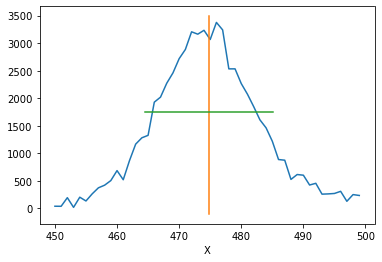

In [17]:
x = np.arange(nx)+450
plt.plot(x,im2[25,:])
plt.plot([mnx,mnx],[-100,maxflx])
plt.plot([-sigx*2.35/2+mnx,sigx*2.35/2+mnx],[0.5*maxflx,0.5*maxflx])
plt.xlabel('X')

Text(0.5, 0, 'Y')

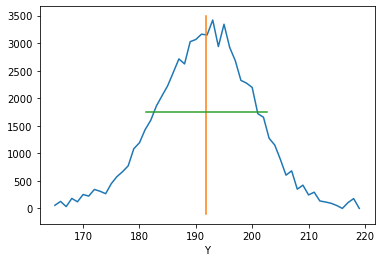

In [18]:
y = np.arange(ny)+165
plt.plot(y,im2[:,25])
plt.plot([mny,mny],[-100,maxflx])
plt.plot([-sigy*2.35/2+mny,sigy*2.35/2+mny],[0.5*maxflx,0.5*maxflx])
plt.xlabel('Y')

# Mixed Moments

In [19]:
sigxy = np.sum(im2*(xx-mnx)*(yy-mny)) / np.sum(im2)
print(sigxy)

-1.002501713464757


In [20]:
asemi = np.sqrt( 0.5*(sigx2+sigy2) + np.sqrt(((sigx2-sigy2)*0.5)**2 + sigxy**2 ) )

In [21]:
bsemi = np.sqrt( 0.5*(sigx2+sigy2) - np.sqrt(((sigx2-sigy2)*0.5)**2 + sigxy**2 ) )

In [22]:
theta = np.rad2deg(0.5*np.arctan2(2*sigxy,sigx2-sigy2))

In [23]:
print(asemi)
print(bsemi)
print(theta)

9.144575953539803
8.772784741313298
-81.24167312077637


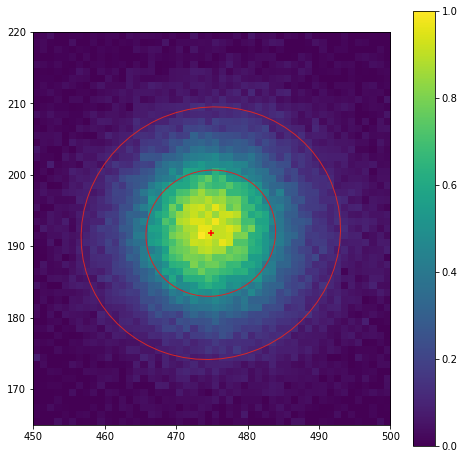

In [24]:
from photutils import EllipticalAperture
position = (mnx,mny)
fig = plt.figure(figsize=(8,8))
plt.imshow(im2,origin='lower',extent=(450,500,165,220))
plt.scatter([mnx],[mny],c='r',marker='+')
apertures = EllipticalAperture(position, asemi, bsemi, theta=theta)
apertures.plot(color='#d62728')
apertures2 = EllipticalAperture(position, 2*asemi, 2*bsemi, theta=theta)
apertures2.plot(color='#d62728')
plt.colorbar()

# Generate a synthetic image

In [25]:
from astropy.modeling.models import Gaussian2D
from photutils.datasets import make_noise_image

In [26]:
def fake_galaxy(x0,y0,amplitude,asemi,bsemi,theta,npix=150):
    """ x0, y0, amplitude, asemi, bsemi, theta (deg), npix wide"""
    g = Gaussian2D(amplitude, x0, y0, asemi, bsemi, theta=np.deg2rad(theta))
    ny = nx = npix
    y, x = np.mgrid[0:npix, 0:npix]
    noise = make_noise_image((ny, nx), distribution='gaussian', mean=0., stddev=2.)
    data = g(x, y) + noise
    return data

In [27]:
data = fake_galaxy(75,75,100.0,20,12,40)

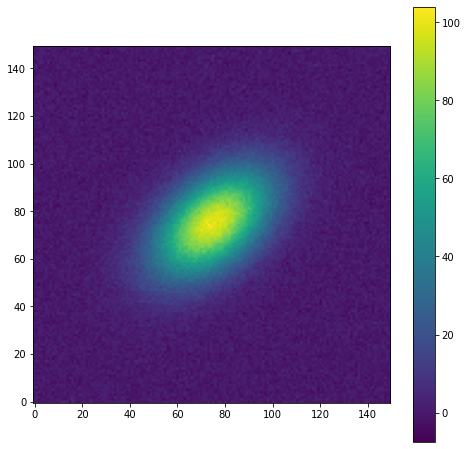

In [28]:
fig = plt.figure(figsize=(8,8))
plt.imshow(data,origin='lower')
plt.colorbar()

In [29]:
# Create array of x-values for the image
ny,nx = data.shape
xx,yy = np.meshgrid(np.arange(nx),np.arange(ny))
# First moments
mnx = np.sum(data*xx) / np.sum(data)
print('mnx = '+str(mnx))
mny = np.sum(data*yy) / np.sum(data)
print('mny = '+str(mny))
# Second moments
sigx2 = np.sum(data*(xx-mnx)**2) / np.sum(data)
sigx = np.sqrt(sigx2)
print('sigx = '+str(sigx))
sigy2 = np.sum(data*(yy-mny)**2) / np.sum(data)
sigy = np.sqrt(sigy2)
print('sigy = '+str(sigy))
sigxy = np.sum(data*(xx-mnx)*(yy-mny)) / np.sum(data)
print('sigxy = '+str(sigxy))
# Ellipse parameters
asemi = np.sqrt( 0.5*(sigx2+sigy2) + np.sqrt(((sigx2-sigy2)*0.5)**2 + sigxy**2 ) )
bsemi = np.sqrt( 0.5*(sigx2+sigy2) - np.sqrt(((sigx2-sigy2)*0.5)**2 + sigxy**2 ) )
theta = np.rad2deg(0.5*np.arctan2(2*sigxy,sigx2-sigy2))
print('a = '+str(asemi))
print('b = '+str(bsemi))
print('theta = '+str(theta))

mnx = 74.97207370721439
mny = 75.11331463574523
sigx = 17.13645947601549
sigy = 15.656257616274079
sigxy = 129.94568481049467
a = 20.03948660408063
b = 11.713053511579892
theta = 39.71038522397759


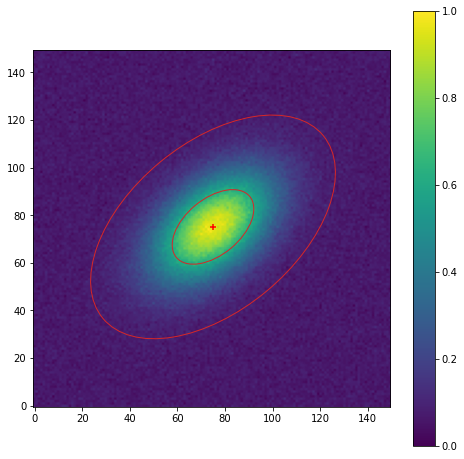

In [30]:
from photutils import EllipticalAperture
position = (mnx,mny)
fig = plt.figure(figsize=(8,8))
plt.imshow(data,origin='lower')
plt.scatter([mnx],[mny],c='r',marker='+')
apertures = EllipticalAperture(position, asemi, bsemi, theta=np.deg2rad(theta))
apertures.plot(color='#d62728')
apertures2 = EllipticalAperture(position, 3*asemi, 3*bsemi, theta=np.deg2rad(theta))
apertures2.plot(color='#d62728')
plt.colorbar()

<font color='blue'>
    <h1>In-class Exercise:</h1>

1) Create three new images using fake_galaxy(), each with different parameters  Use new variables, not ``data``, like ``galaxy1``, ``galaxy2``, ``galaxy3``.

2) Create a function called ``morphology()`` using the code above and have it return a list of the moments and other morophology parameters.
    
3) Get the moments and other morphology parameters for the galaxies.

4) Plot the images with elliptical apertures.
</font>

In [31]:
galaxy  = fake_galaxy(75,75,100.0,12,20,40)
galaxy1 = fake_galaxy(75,75,100.0,20,12,40)
galaxy2 = fake_galaxy(75,75,100.0,12,20,-20)
galaxy3 = fake_galaxy(75,75,50.0,20,6,80)

In [32]:
def morphology(glax):
    # Create array of x-values for the image
    ny,nx = glax.shape
    xx,yy = np.meshgrid(np.arange(nx),np.arange(ny))
    # First moments
    mnx = np.sum(glax*xx) / np.sum(glax)
    mny = np.sum(glax*yy) / np.sum(glax)
    # Second moments
    sigx2 = np.sum(glax*(xx-mnx)**2) / np.sum(glax)
    sigx = np.sqrt(sigx2)
    sigy2 = np.sum(glax*(yy-mny)**2) / np.sum(glax)
    sigy = np.sqrt(sigy2)
    sigxy = np.sum(glax*(xx-mnx)*(yy-mny)) / np.sum(glax)
    # Ellipse parameters
    asemi = np.sqrt( 0.5*(sigx2+sigy2) + np.sqrt(((sigx2-sigy2)*0.5)**2 + sigxy**2 ) )
    bsemi = np.sqrt( 0.5*(sigx2+sigy2) - np.sqrt(((sigx2-sigy2)*0.5)**2 + sigxy**2 ) )
    theta = np.rad2deg(0.5*np.arctan2(2*sigxy,sigx2-sigy2))
    return {"mnx":mnx, "mny":mny, "sigx":sigx, "sigy":sigy, "sigxy":sigxy, "asemi":asemi, "bsemi":bsemi, "theta":theta}

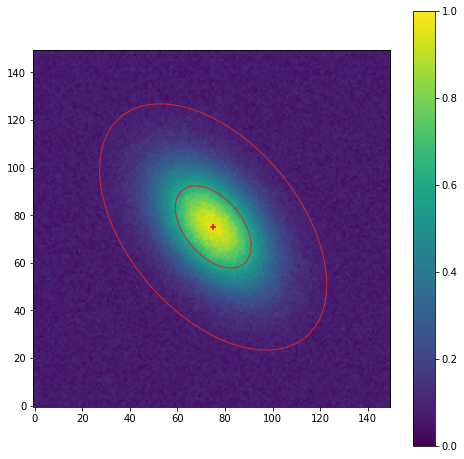

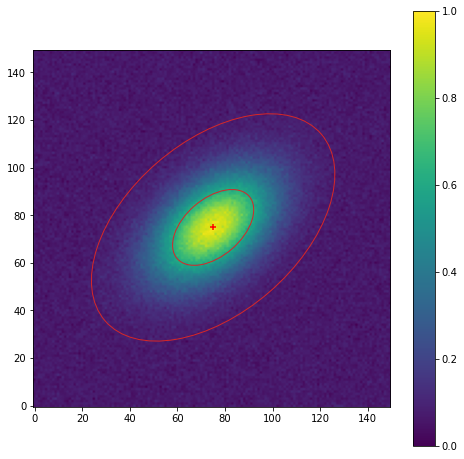

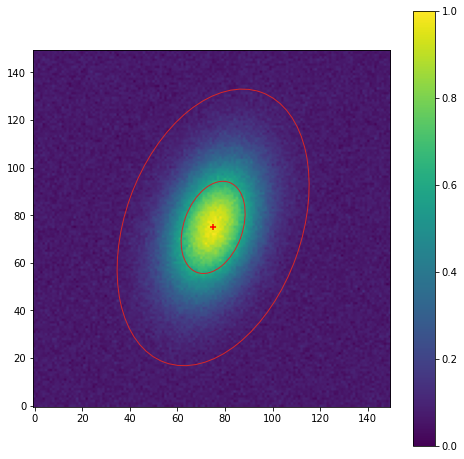

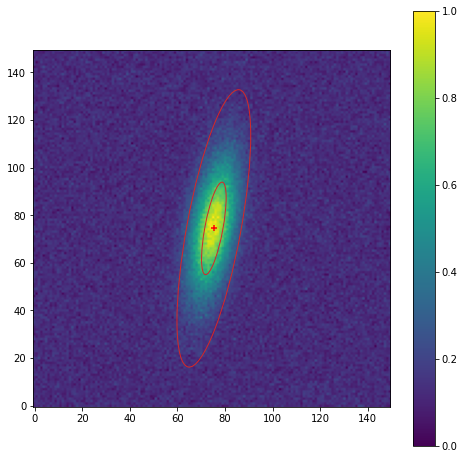

In [33]:
for galx in [galaxy, galaxy1, galaxy2, galaxy3]:
    star_app = morphology(galx)
    position = (star_app['mnx'],star_app['mny'])
    fig = plt.figure(figsize=(8,8))
    plt.imshow(galx,origin='lower')
    plt.scatter([star_app['mnx']],[star_app['mny']],c='r',marker='+')
    apertures = EllipticalAperture(position, star_app['asemi'], star_app['bsemi'], theta=np.deg2rad(star_app['theta']))
    apertures.plot(color='#d62728')
    apertures2 = EllipticalAperture(position, 3*star_app['asemi'], 3*star_app['bsemi'], theta=np.deg2rad(star_app['theta']))
    apertures2.plot(color='#d62728')
    plt.colorbar()
    plt.show()

## photutils morphology

In [34]:
#mn, med, std = sigma_clipped_stats(data, sigma=3.0)
#print(med)
#data -= med  # subtract background
#data[data<0]=0

In [35]:
from photutils.morphology import data_properties
cat = data_properties(data)

In [36]:
tbl = cat.to_table()

In [37]:
tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,74.92504543966835,74.97137585929703,None,0,149,0,149,22500.0,23.23773125678791,18.006416960240845,39.70888779506432,0.6321102769559648,-7.4771997637894225,103.93197531010357,0.0,150729.82922415054,nan,149250.2033432476,nan


In [38]:
print(cat.semimajor_sigma.value)
print(cat.semiminor_sigma.value)
print(cat.orientation.value)

23.23773125678791
18.006416960240845
39.70888779506432


In [39]:
from photutils.segmentation import SourceProperties

(<matplotlib.patches.Ellipse at 0x166539c4070>,)

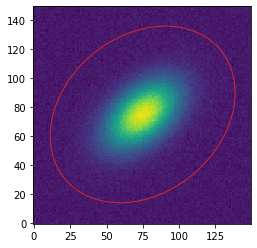

In [40]:
import astropy.units as u
from photutils import EllipticalAperture
position = (cat.xcentroid, cat.ycentroid)
r = 3.0  # approximate isophotal extent
a = cat.semimajor_sigma.value * r
b = cat.semiminor_sigma.value * r
theta = cat.orientation.to(u.rad).value
apertures = EllipticalAperture(position, a, b, theta=theta)
plt.imshow(data, origin='lower', cmap='viridis',interpolation='nearest')
apertures.plot(color='#d62728')

<font color='blue'>
<h1>In-class Exercise:</h1>
    
1) Get photutils morophology for your fake galaxy images using data_properties().
</font>

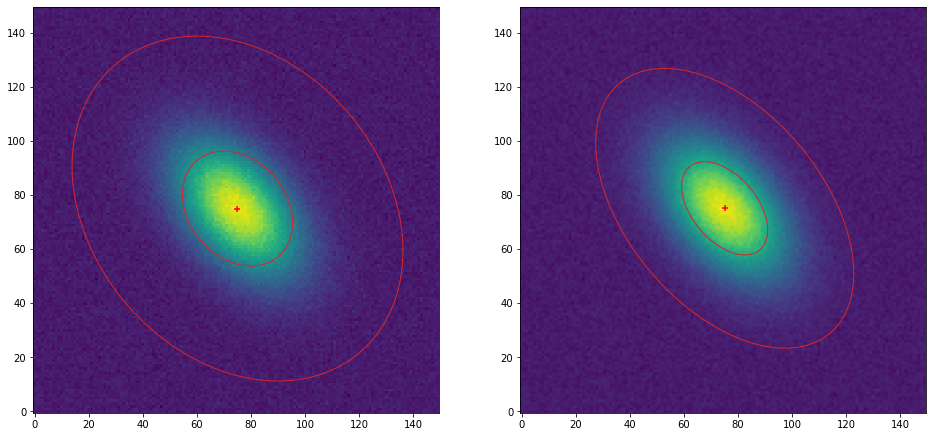

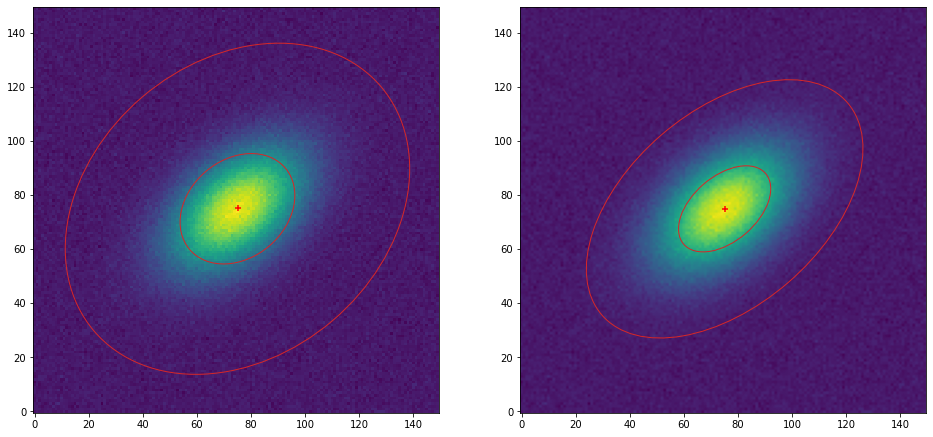

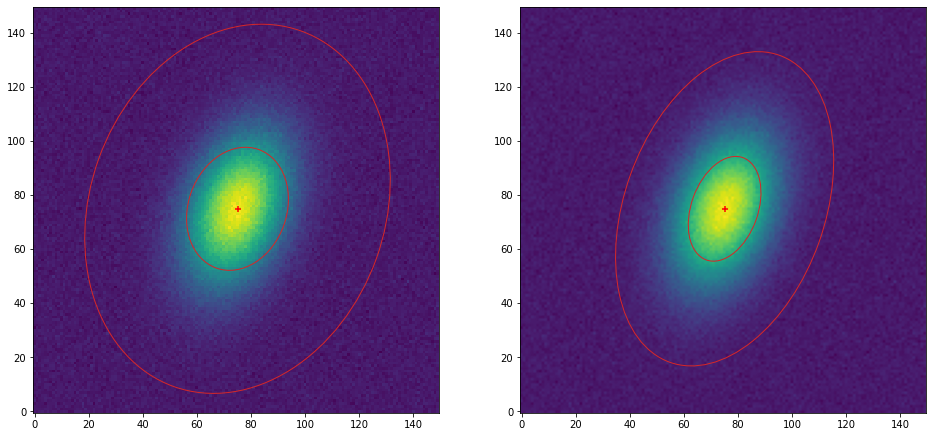

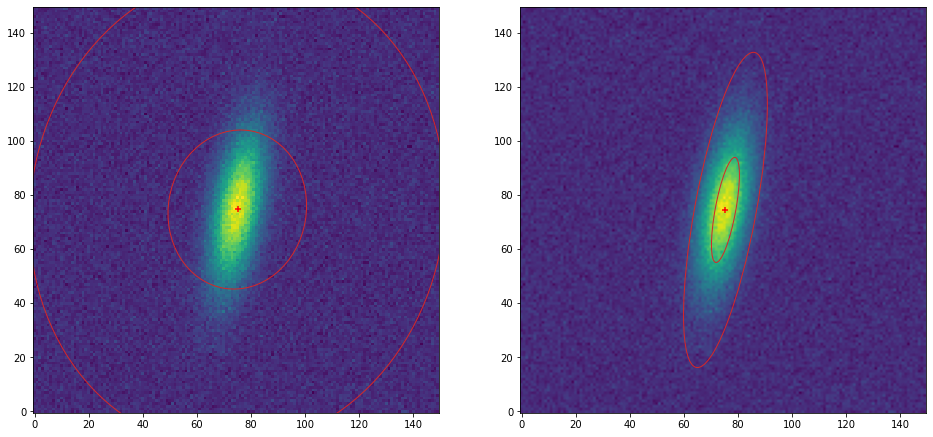

In [41]:
for galx in [galaxy, galaxy1, galaxy2, galaxy3]:
    fig = plt.figure(figsize=(16,24))
    plt.subplot(121)
    cat1 = data_properties(galx)
    tbl1 = cat1.to_table()
    position1 = (cat1.xcentroid, cat1.ycentroid)
    r1 = 3.0  # approximate isophotal extent
    a1 = cat1.semimajor_sigma.value
    b1 = cat1.semiminor_sigma.value
    theta1 = cat1.orientation.to(u.rad).value
    apertures1 = EllipticalAperture(position1, a1, b1, theta=theta1)
    apertures2 = EllipticalAperture(position1, a1*r1, b1*r1, theta=theta1)
    plt.scatter(*position,c='r',marker='+')
    plt.imshow(galx, origin='lower', cmap='viridis',interpolation='nearest')
    apertures1.plot(color='#d62728')
    apertures2.plot(color='#d62728')
    
    plt.subplot(122)
    star_app = morphology(galx)
    position = (star_app['mnx'],star_app['mny'])
    plt.imshow(galx,origin='lower')
    plt.scatter([star_app['mnx']],[star_app['mny']],c='r',marker='+')
    apertures1 = EllipticalAperture(position, star_app['asemi'], star_app['bsemi'], theta=np.deg2rad(star_app['theta']))
    apertures1.plot(color='#d62728')
    apertures2 = EllipticalAperture(position, r1*star_app['asemi'], r1*star_app['bsemi'], theta=np.deg2rad(star_app['theta']))
    apertures2.plot(color='#d62728')
    
    plt.show()

# Elliptical Aperture Photometry

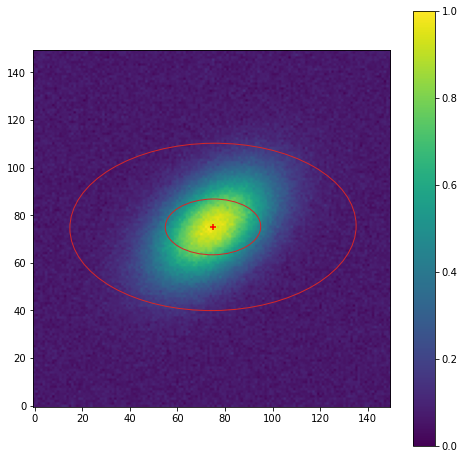

In [42]:
from photutils import EllipticalAperture
position = (mnx,mny)
fig = plt.figure(figsize=(8,8))
plt.imshow(data,origin='lower')
plt.scatter([mnx],[mny],c='r',marker='+')
apertures = EllipticalAperture(position, asemi, bsemi, theta=np.deg2rad(theta))
apertures.plot(color='#d62728')
apertures2 = EllipticalAperture(position, 3*asemi, 3*bsemi, theta=np.deg2rad(theta))
apertures2.plot(color='#d62728')
plt.colorbar()

In [43]:
aperture = EllipticalAperture(position, 3*asemi, 3*bsemi, theta=np.deg2rad(theta))
tab = aperture_photometry(data, aperture)

In [44]:
tab

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,74.97207370721439,75.11331463574523,144624.389180467


<font color='blue'>
<h1>In-class Exercise:</h1>

1) Use an elliptical aperture (r=3) to get the total flux enclosed in your fake galaxies.
</font>

In [58]:
r = 3
for galx in [galaxy, galaxy1, galaxy2, galaxy3]:
    star_app = morphology(galx)
    position = (star_app['mnx'],star_app['mny'])
    aperture = EllipticalAperture(position, r*star_app['asemi'], r*star_app['bsemi'], theta=np.deg2rad(star_app['theta']))
    star_flux_tab = aperture_photometry(galx, aperture)
    star_flux = star_flux_tab['aperture_sum']
    print(f"Appiture sum (morph): {star_flux}")
    
    cat1 = data_properties(galx)
    theta1 = cat1.orientation.to(u.rad).value
    aperture = EllipticalAperture((cat1.xcentroid, cat1.ycentroid), r*cat1.semimajor_sigma.value, r*cat1.semiminor_sigma.value, theta=theta1)
    star_flux_tab = aperture_photometry(galx, aperture)
    star_flux = star_flux_tab['aperture_sum']
    print(f"Appiture sum (phot):  {star_flux}\n")

Appiture sum (morph):    aperture_sum   
------------------
149247.75464392858
Appiture sum (phot):     aperture_sum   
------------------
150702.22490213843

Appiture sum (morph):    aperture_sum  
-----------------
149298.3151755717
Appiture sum (phot):     aperture_sum  
-----------------
150819.5736175818

Appiture sum (morph):   aperture_sum  
----------------
149401.892235026
Appiture sum (phot):     aperture_sum  
-----------------
150880.1767536756

Appiture sum (morph):    aperture_sum   
------------------
34413.077446802614
Appiture sum (phot):    aperture_sum  
----------------
37315.5507494701

